In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# 1. Custom Feedback Alignment Function
class FA_Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias, B):
        ctx.save_for_backward(input, weight, bias, B)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias, B = ctx.saved_tensors
        grad_weight = grad_output.t().mm(input)
        grad_bias = grad_output.sum(0) if bias is not None else None
        # FA CORE: Use fixed random matrix B
        grad_input = grad_output.mm(B) 
        return grad_input, grad_weight, grad_bias, None

class FALinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.B = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad=False)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.weight, -0.01, 0.01)
        nn.init.uniform_(self.bias, -0.01, 0.01)
        nn.init.uniform_(self.B, -0.5, 0.5)

    def forward(self, x):
        return FA_Function.apply(x, self.weight, self.bias, self.B)


In [3]:
# 2. Network Architectures
class LearnerNet(nn.Module):
    def __init__(self, dims, use_fa=False, shallow=False):
        super().__init__()
        layers = []
        for i in range(len(dims) - 1):
            if use_fa and i < len(dims) - 2:
                layers.append(FALinear(dims[i], dims[i+1]))
            else:
                layers.append(nn.Linear(dims[i], dims[i+1]))
                nn.init.uniform_(layers[-1].weight, -0.01, 0.01)
                nn.init.uniform_(layers[-1].bias, -0.01, 0.01)
            if i < len(dims) - 2:
                layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
        if shallow:
            for param in list(self.parameters())[:-2]:
                param.requires_grad = False

    def forward(self, x):
        return self.model(x)

In [4]:
# 3. Experiment Settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ITERATIONS = 400000
BATCH_SIZE = 100 # Changed to 100 to align with LOG_INTERVAL
TRIALS = 10
LOG_INTERVAL = 2000

configs = {
    "Shallow (3-layer)":  {"dims": [30, 20, 10],     "fa": False, "shallow": True,  "color": "grey"},
    "Backprop (3-layer)": {"dims": [30, 20, 10],     "fa": False, "shallow": False, "color": "black"},
    "FA (3-layer)":       {"dims": [30, 20, 10],     "fa": True,  "shallow": False, "color": "green"},
    "Backprop (4-layer)": {"dims": [30, 20, 10, 10], "fa": False, "shallow": False, "color": "magenta"},
    "FA (4-layer)":       {"dims": [30, 20, 10, 10], "fa": True,  "shallow": False, "color": "blue"}
}

all_results = {name: [] for name in configs}

In [5]:
# 4. Training Loop
for trial in range(TRIALS):
    print(f"\nTrial {trial+1}/{TRIALS}")
    
    # Target Network (Fixed)
    target_net = nn.Sequential(
        nn.Linear(30, 20), nn.Tanh(), 
        nn.Linear(20, 10), nn.Tanh(), 
        nn.Linear(10, 10)
    ).to(device)
    for p in target_net.parameters(): p.requires_grad = False

    # Variance for NSE
    with torch.no_grad():
        v_y = target_net(torch.randn(10000, 30).to(device))
        target_variance = torch.var(v_y).item()

    for name, conf in configs.items():
        model = LearnerNet(conf['dims'], use_fa=conf['fa'], shallow=conf['shallow']).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.MSELoss()
        
        trial_history = []
        for i in range(0, ITERATIONS, BATCH_SIZE):
            x = torch.randn(BATCH_SIZE, 30).to(device)
            with torch.no_grad(): y_star = target_net(x)
            
            y = model(x)
            loss = criterion(y, y_star)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % LOG_INTERVAL == 0:
                trial_history.append(loss.item() / target_variance)
        
        all_results[name].append(trial_history)
        print(f"  Finished {name}")



Trial 1/10
  Finished Shallow (3-layer)
  Finished Backprop (3-layer)
  Finished FA (3-layer)
  Finished Backprop (4-layer)
  Finished FA (4-layer)

Trial 2/10
  Finished Shallow (3-layer)
  Finished Backprop (3-layer)
  Finished FA (3-layer)
  Finished Backprop (4-layer)
  Finished FA (4-layer)

Trial 3/10
  Finished Shallow (3-layer)
  Finished Backprop (3-layer)
  Finished FA (3-layer)
  Finished Backprop (4-layer)
  Finished FA (4-layer)

Trial 4/10
  Finished Shallow (3-layer)
  Finished Backprop (3-layer)
  Finished FA (3-layer)
  Finished Backprop (4-layer)
  Finished FA (4-layer)

Trial 5/10
  Finished Shallow (3-layer)
  Finished Backprop (3-layer)
  Finished FA (3-layer)
  Finished Backprop (4-layer)
  Finished FA (4-layer)

Trial 6/10
  Finished Shallow (3-layer)
  Finished Backprop (3-layer)
  Finished FA (3-layer)
  Finished Backprop (4-layer)
  Finished FA (4-layer)

Trial 7/10
  Finished Shallow (3-layer)
  Finished Backprop (3-layer)
  Finished FA (3-layer)
  Finished 

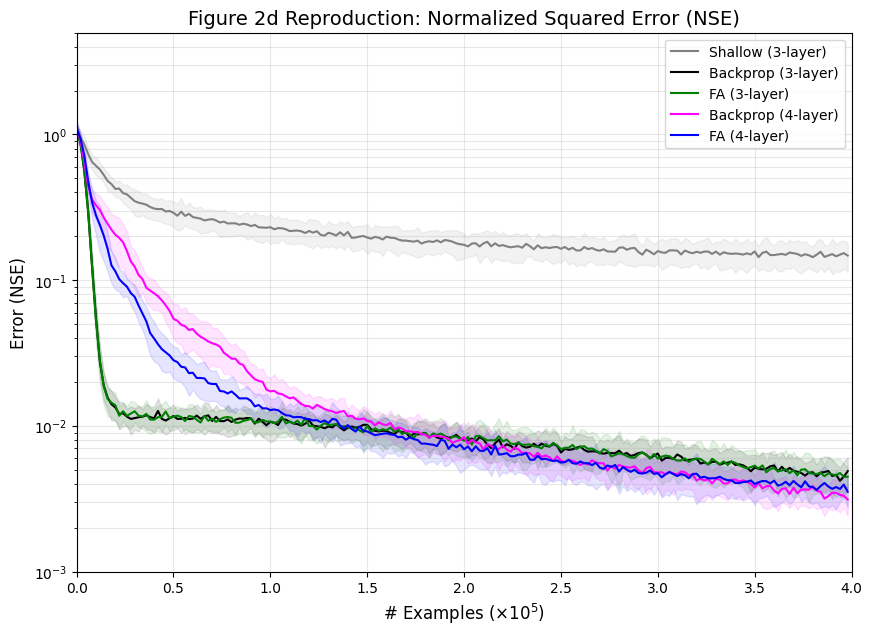

In [6]:
# 5. Plotting (Corrected Dimensions)
plt.figure(figsize=(10, 7))
# x_axis_scaled will have exactly the same number of elements as trial_history
x_axis_scaled = np.arange(0, ITERATIONS, LOG_INTERVAL) / 100000

for name, trial_data in all_results.items():
    data_array = np.array(trial_data) # Shape (Trials, TimeSteps)
    mean_nse = np.mean(data_array, axis=0)
    std_nse = np.std(data_array, axis=0)
    
    color = configs[name]['color']
    plt.plot(x_axis_scaled, mean_nse, label=name, color=color, linewidth=1.5)
    plt.fill_between(x_axis_scaled, mean_nse - std_nse, mean_nse + std_nse, color=color, alpha=0.1)

plt.yscale('log')
plt.title("Figure 2d Reproduction: Normalized Squared Error (NSE)", fontsize=14)
plt.xlabel(r"# Examples ($\times 10^5$)", fontsize=12)
plt.ylabel("Error (NSE)", fontsize=12)
plt.xlim(0, ITERATIONS / 100000)
plt.ylim(1e-3, 5)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend(loc='upper right')
plt.show()